See https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf for more information about 1d convolutions and time series classification

In [1]:
# Install packages with the correct version for X-Cube AI
!pip install tensorflow==2.1.0 h5py==2.10.0 samplerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 24 kB/s 
     |████████████████████████████████| 2.9 MB 42.0 MB/s 
     |████████████████████████████████| 4.0 MB 54.1 MB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
     |████████████████████████████████| 3.8 MB 58.1 MB/s 
     |████████████████████████████████| 448 kB 69.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6d70170f90f3265fe8c8ac457cf65cede6f8565fab696c16f2650271b7ec957b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-es

In [ ]:
# Check if tensorflow finds the runtime GPU
import tensorflow as tf


print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

2.1.0
Found GPU at: /device:GPU:0


In [2]:
# Clone the repository

Cloning into 'fc_crash-detection'...
remote: Enumerating objects: 18779, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 18779 (delta 13), reused 9 (delta 4), pack-reused 18749
Receiving objects: 100% (18779/18779), 2.00 GiB | 24.07 MiB/s, done.
Resolving deltas: 100% (835/835), done.
Checking out files: 100% (16051/16051), done.


In [3]:
# Mount Google Drive
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set params
dataset_path = '/content/fc_crash-detection/crash-dataset-csv/infobox'
STM32_dataset_path = '/content/drive/MyDrive/STM32_dataset/infobox' # Where to save test set
results_path = '/content/drive/MyDrive'
model_name = 'infobox_xy_1200_1' # In results_path
mode = "time" # time or fft
test_split = 0.05
validation_split = 0.1
max_epoch = 1000
min_delta = 0
patience = 100

In [5]:
# Define some functions
from tqdm.notebook import tqdm
from scipy.fft import fft
import numpy as np
import pandas as pd
import samplerate
import glob
import os


def preprocess_infobox(entry):
  # Decide hardware version based on recording lenght
  # rev 1
  if (len(entry)) > 3100:
    # Get records for which sampling freq is 400Hz
    # Get only col 4 and 5 (filtered x and y accelerometers)
    #loaded_entry = entry.values[500:2900,4:6]
    # Make infobox sample similar to microbox
    loaded_entry = entry.values[900:2100,4:6]

  # rev 2,3
  else:
    if (len(entry)) > 3050:
      loaded_entry = entry.values[59:3059,4:6]
    else:
      loaded_entry = entry.values[0:3000,4:6]

    # All records have sampling freq of 1000Hz
    # Get only col 4 and 5 (filtered x and y accelerometers)
    #loaded_entry = entry.values[59:3059,4:6]
    
    # Resample 1000Hz to 400Hz -> ratio = out_freq / in_freq
    ratio = 0.4
    converter = 'sinc_best'  # Or 'sinc_fastest', ...
    loaded_entry = samplerate.resample(loaded_entry, ratio, converter)

    # Pad matrix length difference with the last recorded value for each axis with mode = 'edge'
    #diff = 2400 - len(loaded_entry)
    # Pad_width format for 2d vectors: ((top, bottom), (left, right))
    #loaded_entry = np.pad(loaded_entry, ((0,diff),(0,0)), mode = 'edge')

  # 3000 length recording have cleaner sensor data!!

  return loaded_entry


def get_dataset(path):

  entry_list = []

  files_list = glob.glob(os.path.join(path, "*.csv"))
  # Load every csv inside path as a numpy matrix, preprocess and create a list
  for filename in tqdm(files_list):
    ds_entry = pd.read_csv(filename, index_col=None, header=0)
    ds_entry_processed = preprocess_infobox(ds_entry)

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_entry_processed[:,0])
      fft_y = fft(ds_entry_processed[:,1])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)

      ds_entry_fft = np.stack([d_x, d_y], axis=1)
      entry_list.append(ds_entry_fft)

    if mode == "time":
      entry_list.append(ds_entry_processed)
  
  # Convert list to a numpy array. Cast to float32 to avoid errors on fit
  ds_array = np.asarray(entry_list).astype('float32')

  return ds_array

In [6]:
# Load data
import numpy as np


ds_false = get_dataset(dataset_path + '/false')
ds_true = get_dataset(dataset_path + '/true')

# Build all-false labels (one hot encoding, two classes, two columns)
ds_false_labels = np.zeros((len(ds_false),2))
# Set all first column to one
ds_false_labels[:,0] = 1
print("False-class data:")
print(ds_false.shape)
print(ds_false_labels.shape)

# Build all-true labels (one hot encoding, two classes, two columns)
ds_true_labels = np.zeros((len(ds_true),2))
# Set all second column to one
ds_true_labels[:,1] = 1
print("\nTrue-class data:")
print(ds_true.shape)
print(ds_true_labels.shape)

# Concatenate false-class/true-class data and labels
ds_all = np.concatenate((ds_false, ds_true), axis = 0)
ds_all_labels = np.concatenate((ds_false_labels, ds_true_labels), axis = 0)
print("\nAll data:")
print(ds_all.shape)
print(ds_all_labels.shape)
del ds_false, ds_true, ds_false_labels, ds_true_labels

  0%|          | 0/3045 [00:00<?, ?it/s]

  0%|          | 0/3045 [00:00<?, ?it/s]

False-class data:
(3045, 1200, 2)
(3045, 2)

True-class data:
(3045, 1200, 2)
(3045, 2)

All data:
(6090, 1200, 2)
(6090, 2)


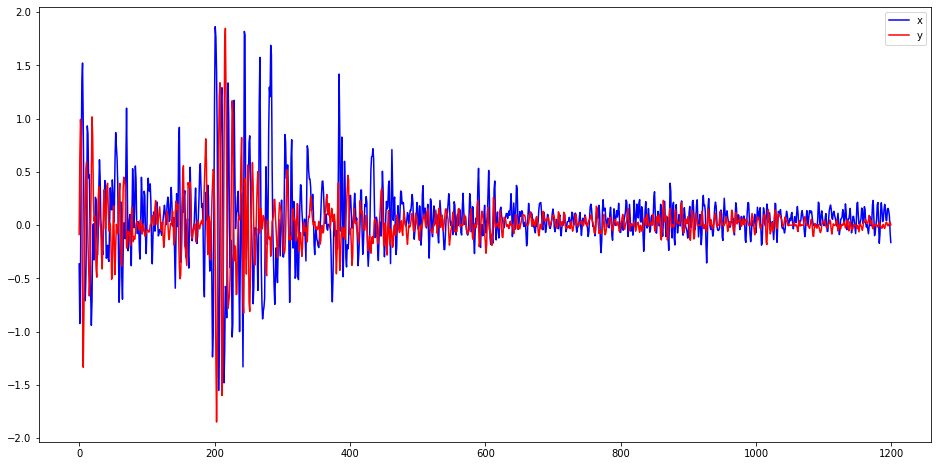

In [9]:
# Plot a single sample of data
from matplotlib import pyplot as plt
import numpy as np
import random


sample = random.randint(0, ds_all.shape[0])
x = np.arange(0,len(ds_all[sample]))

fig = plt.figure(figsize=(16,8))
plt.plot(x, ds_all[sample,:,0], "blue", label="x")
plt.plot(x, ds_all[sample,:,1], "red", label="y")
plt.legend(loc="upper right")
plt.show()

In [7]:
# Create train and test splits
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(ds_all, ds_all_labels, test_size = test_split)

print("Train split:")
print(X_train.shape)
print(y_train.shape)

print("\nTest split:")
print(X_test.shape)
print(y_test.shape)

Train split:
(5785, 1200, 2)
(5785, 2)

Test split:
(305, 1200, 2)
(305, 2)


In [8]:
# Create the model
import tensorflow as tf
from tensorflow.keras.layers import Activation,Dense,Dropout,Conv1D,Flatten,MaxPooling1D,GlobalAveragePooling1D


# Model definition
model = tf.keras.Sequential()

input_shape=(X_train.shape[1],X_train.shape[2])
model.add(Conv1D(110, 20, activation='relu', input_shape=input_shape)) #120, 20
#model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(16))
model.add(Dropout(0.5))
model.add(Conv1D(100, 10, activation='relu')) #100, 10
#model.add(Conv1D(80, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Define optimizer, learning rate, and compile model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1181, 110)         4510      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 110)           0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 110)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 100)           110100    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2

Train on 5206 samples, validate on 579 samples
Epoch 1/1000
4992/5206 [===========================>..] - ETA: 0s - loss: 0.5977 - accuracy: 0.7456 - AUC: 0.8010
Epoch 00001: val_accuracy improved from -inf to 0.86010, saving model to /content/infobox_xy_1200_1.h5
5206/5206 [==============================] - 6s 1ms/sample - loss: 0.5916 - accuracy: 0.7497 - AUC: 0.8057 - val_loss: 0.4520 - val_accuracy: 0.8601 - val_AUC: 0.9015
Epoch 2/1000
4992/5206 [===========================>..] - ETA: 0s - loss: 0.4336 - accuracy: 0.8383 - AUC: 0.8988
Epoch 00002: val_accuracy did not improve from 0.86010
5206/5206 [==============================] - 1s 210us/sample - loss: 0.4364 - accuracy: 0.8363 - AUC: 0.8968 - val_loss: 0.4342 - val_accuracy: 0.8480 - val_AUC: 0.8962
Epoch 3/1000
4992/5206 [===========================>..] - ETA: 0s - loss: 0.3991 - accuracy: 0.8427 - AUC: 0.9112
Epoch 00003: val_accuracy improved from 0.86010 to 0.86183, saving model to /content/infobox_xy_1200_1.h5
5206/5206 [

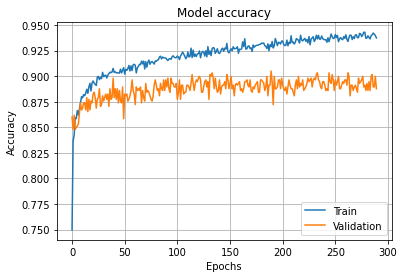

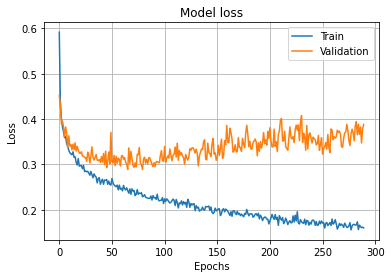

In [9]:
# Train
from matplotlib import pyplot as plt
import tensorflow as tf


checkpoint = tf.keras.callbacks.ModelCheckpoint(results_path + '/' + model_name + '.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=min_delta, patience=patience, verbose=1, mode='auto')

history = model.fit(X_train, y_train, validation_split = validation_split, epochs = max_epoch, callbacks = [checkpoint, early], shuffle = True)

# Accuracy
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
fig1.savefig(results_path + '/' + model_name + '_model_accuracy.png')
plt.show()
# Loss
fig2 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
fig2.savefig(results_path + '/' + model_name + '_model_loss.png')
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1181, 110)         4510      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 110)           0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 110)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 100)           110100    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2

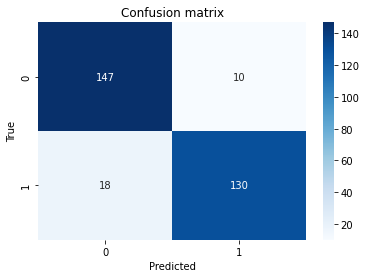

In [10]:
# Test
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from tensorflow import keras
import seaborn as sns
import pandas as pd


model = keras.models.load_model(results_path + '/' + model_name + '.h5')
model.summary()
results = model.evaluate(X_test, y_test)

print('\nTest Loss, Test Accuracy, Test AUC:', results)

# Generate confusion matrix and compute metrics
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred)
tn, fp, fn, tp = conf_mat.ravel()
precision = precision_score(y_test.argmax(axis=1), y_pred)
recall = recall_score(y_test.argmax(axis=1), y_pred)
f1_score = f1_score(y_test.argmax(axis=1), y_pred)

print('\nPrecision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(f1_score))
print('\nTrue Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))
print('True Positives: ' + str(tp) + '\n')

fig = plt.figure()
sns.heatmap(conf_mat, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
fig.savefig(results_path + '/' + model_name + '_confusion_matrix.png')
plt.show()

data = {'a': [results[0], results[1], results[2], precision, recall, f1_score, tn, fp, fn, tp]}
df = pd.DataFrame(data=data, index=['Test Loss', 'Test Accuracy', 'Test AUC', 'Precision', 'Recall', 'F1-score', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'])
df.to_csv(results_path + '/' + model_name + '_results.csv', header=False)

In [ ]:
# Save test dataset for STM32
import csv
import os


# Compute max bytes to read for STM32 application
max_btr = 0
for i in range(0,len(X_test)):
  l = 0
  for j in range(0,len(X_test[0])):
    for k in range(0,len(X_test[0][0])):
      l = l + len(str(X_test[i][j][k]))
    l = l + 3 # Extra bytes per row
  if l > max_btr:
    max_btr = l
max_btr = max_btr + 9 # Extra bytes for first and last row (first 6, last 3)

if len(os.listdir(STM32_dataset_path + '/false')) == 0 and len(os.listdir(STM32_dataset_path + '/true')) == 0:
  for i in range(0,len(X_test)):
    if y_test[i][1] == 1:
      test_class = "true"
    else:
      test_class = "false"
    with open(STM32_dataset_path + '/' + test_class + '/' + test_class + '_' + str(i+1) + '.csv', 'w') as csvfile:
      writer = csv.writer(csvfile)
      btr = 0
      buffer = ""
      writer.writerow(["","   "])
      for j in range(0, len(X_test[0])):
        len_x = len(str(X_test[i][j][0]))
        len_y = len(str(X_test[i][j][1]))
        btr = btr + len_x + len_y + 3
        writer.writerow([str(X_test[i][j][0]), str(X_test[i][j][1])])
      btr = btr + 9
      for buf in range(0, max_btr - btr):
        buffer = buffer + " "
      writer.writerow(["", buffer])

print("BTR: " + str(max_btr))

BTR: 32871
